In [7]:
# %% [markdown]
# # Автоматизированный пайплайн для House Prices в Jupyter Notebook

# %%
# 1. Импорты
import zipfile
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:

# %%
# 2. Функции пайплайна

def unzip_data(zip_path: Path, extract_dir: Path):
    extract_dir.mkdir(exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)

def load_data(data_dir: Path):
    train = pd.read_csv(data_dir / "train.csv")
    test  = pd.read_csv(data_dir / "test.csv")
    return train, test


In [6]:
# 3. Распаковка и загрузка данных
zip_path = Path("./mental-health-prediction.zip")
data_dir = Path("./data")
unzip_data(zip_path, data_dir)
train, test = load_data(data_dir)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   1891 non-null   object 
 1   Gender                                 1891 non-null   object 
 2   Age                                    1891 non-null   int64  
 3   City                                   1891 non-null   object 
 4   Working Professional or Student        1891 non-null   object 
 5   Profession                             1380 non-null   object 
 6   Academic Pressure                      382 non-null    float64
 7   Work Pressure                          1509 non-null   float64
 8   CGPA                                   382 non-null    float64
 9   Study Satisfaction                     382 non-null    float64
 10  Job Satisfaction                       1509 non-null   float64
 11  Slee

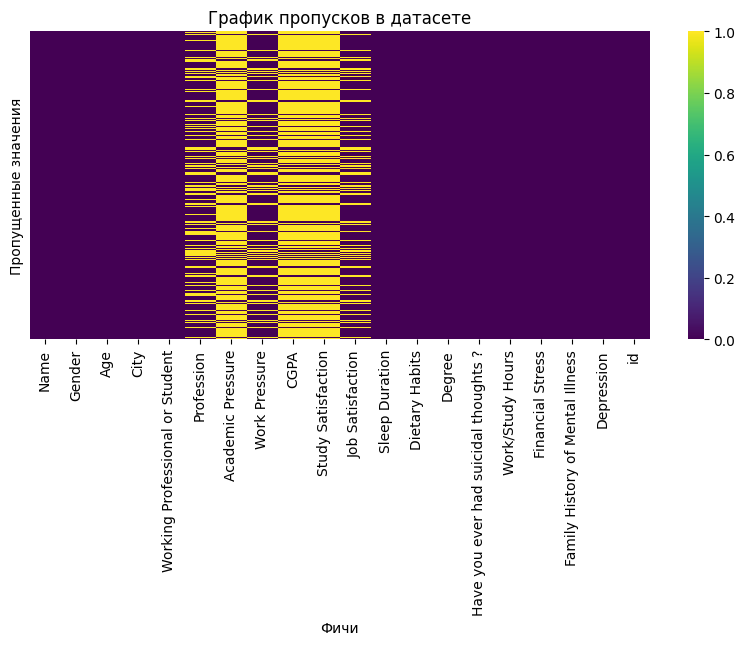

In [15]:
# train.head()
train.info()
train.shape



Academic Pressure     1509
CGPA                  1509
Study Satisfaction    1509
Profession             511
Work Pressure          382
Job Satisfaction       382
dtype: int64


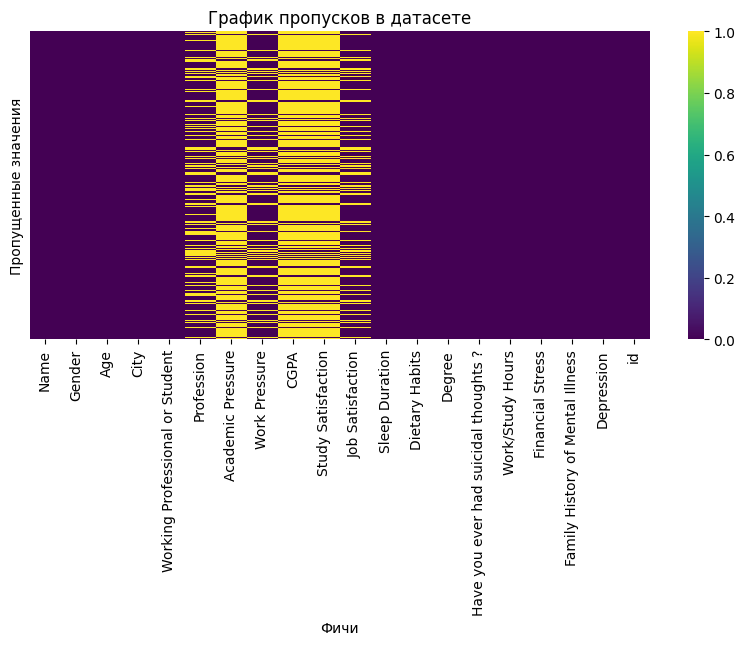

In [16]:
missing_data = train.isna()
print(missing_data.sum().loc[lambda x: x > 0].sort_values(ascending=False))

plt.figure(figsize=(10, 4))
sns.heatmap(missing_data, yticklabels=False, cmap='viridis')
plt.title("График пропусков в датасете")
plt.xlabel("Фичи")
plt.ylabel("Пропущенные значения")
plt.show()

In [ ]:
def build_preprocessor(train_df: pd.DataFrame):
    """
    Возвращает ColumnTransformer и списки признаков:
    - числовые: SimpleImputer(median) + StandardScaler
    - категориальные: SimpleImputer(constant) + OneHotEncoder(sparse_output=False)
    """
    df = train_df.drop(columns=["Id", "SalePrice"])
    num_feats = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_feats = df.select_dtypes(include=["object"]).columns.tolist()

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ("num", num_pipe, num_feats),
        ("cat", cat_pipe, cat_feats)
    ])
    return preprocessor, num_feats, cat_feats